## Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

import utils.training as train_utils; imp.reload(train_utils)
#import utils.plot as plot_utils; imp.reload(plot_utils)

import camvid_dataset as camvid
import joint_transforms
%matplotlib inline

In [2]:
DATA_PATH='data/'
RESULTS_PATH='results/'
WEIGHTS_PATH='models/'
CAMVID_PATH=DATA_PATH+'CamVid/'
PROJECT_NAME='tiramisu'

## Design

**FirstConvLayer**

* 3x3 Conv2D (pad=, stride=, in_chans=3, out_chans=48)

**DenseLayer**

* BatchNorm
* ReLU
* 3x3 Conv2d (pad=, stride=, in_chans=, out_chans=) - "no resolution loss" - padding included
* Dropout (.2)

**DenseBlock**

* Input = FirstConvLayer, TransitionDown, or TransitionUp
* Loop to create L DenseLayers (L=n_layers)
* On TransitionDown we Concat(Input, FinalDenseLayerActivation)
* On TransitionUp we do not Concat with input, instead pass FinalDenseLayerActivation to TransitionUp block

**TransitionDown**

* BatchNorm
* ReLU
* 1x1 Conv2D (pad=, stride=, in_chans=, out_chans=)
* Dropout (0.2)
* 2x2 MaxPooling

**Bottleneck**

* DenseBlock (15 layers)

**TransitionUp**

* 3x3 Transposed Convolution (pad=, stride=2, in_chans=, out_chans=)
* Concat(PreviousDenseBlock, SkipConnection) - from cooresponding DenseBlock on transition down

**FinalBlock**

* 1x1 Conv2d (pad=, stride=, in_chans=256, out_chans=n_classes)
* Softmax

**FCDenseNet103 Architecture**

* input (in_chans=3 for RGB)
* 3x3 ConvLayer (out_chans=48)
* DB (4 layers) + TD
* DB (5 layers) + TD
* DB (7 layers) + TD
* DB (10 layers) + TD
* DB (12 layers) + TD
* Bottleneck (15 layers)
* TU + DB (12 layers)
* TU + DB (10 layers)
* TU + DB (7 layers)
* TU + DB (5 layers)
* TU + DB (4 layers)
* 1x1 ConvLayer (out_chans=n_classes) n_classes=11 for CamVid
* Softmax

**FCDenseNet67**

* GrowthRate (k) = 16
* 5 layers per dense block
* 1 Conv Layer
* 5 DenseBlocks Downsample (25 layers)
* 5 TransitionDown
* 5 Bottleneck layers
* 5 Dense Blocks Upsample (25 layers)
* 5 TransitionUp
* 1 Conv Layer
* 1 Softmax layer (doesn't count)
67 Total layers

**360x480 Input Path**
* skipsize torch.Size([1, 128, 360, 480])
* skipsize torch.Size([1, 208, 180, 240])
* skipsize torch.Size([1, 288, 90, 120])
* skipsize torch.Size([1, 368, 45, 60])
* skipsize torch.Size([1, 448, 22, 30])
* bnecksize torch.Size([1, 80, 11, 15])
* insize torch.Size([1, 80, 11, 15])
* outsize torch.Size([1, 80, 22, 30])
* insize torch.Size([1, 80, 22, 30])
* outsize torch.Size([1, 80, 45, 60])
* insize torch.Size([1, 80, 45, 60])
* outsize torch.Size([1, 80, 90, 120])
* insize torch.Size([1, 80, 90, 120])
* outsize torch.Size([1, 80, 180, 240])
* insize torch.Size([1, 80, 180, 240])
* outsize torch.Size([1, 80, 360, 480])

**224x224 Input Path**
* skipsize torch.Size([3, 128, 224, 224])
* skipsize torch.Size([3, 208, 112, 112])
* skipsize torch.Size([3, 288, 56, 56])
* skipsize torch.Size([3, 368, 28, 28])
* skipsize torch.Size([3, 448, 14, 14])
* bnecksize torch.Size([3, 80, 7, 7])
* insize torch.Size([3, 80, 7, 7])
* outsize torch.Size([3, 80, 14, 14])
* insize torch.Size([3, 80, 14, 14])
* outsize torch.Size([3, 80, 28, 28])
* insize torch.Size([3, 80, 28, 28])
* outsize torch.Size([3, 80, 56, 56])
* insize torch.Size([3, 80, 56, 56])
* outsize torch.Size([3, 80, 112, 112])
* insize torch.Size([3, 80, 112, 112])
* outsize torch.Size([3, 80, 224, 224])

## Layers

In [3]:
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
                padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
    
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

## Model

In [4]:
#https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
#Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
def center_crop(layer, max_height, max_width):
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

In [5]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, n_blocks=5, layers_per_block=5, growth_rate=16, 
                 out_chans_first_conv=48, n_classes=12):
        super(FCDenseNet, self).__init__()
        self.n_blocks = n_blocks
        self.n_channels = 0
        self.skipNumChannels = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        self.n_channels = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(n_blocks):
            self.denseBlocksDown.append(
                DenseBlock(self.n_channels, growth_rate, layers_per_block))
            self.n_channels += (growth_rate*layers_per_block)
            self.skipNumChannels.insert(0,self.n_channels)
            self.transDownBlocks.append(TransitionDown(self.n_channels))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(self.n_channels, 
                                     growth_rate, layers_per_block))
        prev_block_channels = growth_rate*layers_per_block
        self.n_channels += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(n_blocks-1):
            self.transUpBlocks.append(TransitionUp(
                growth_rate*layers_per_block, growth_rate*layers_per_block))
            self.n_channels = prev_block_channels + self.skipNumChannels[i]

            self.denseBlocksUp.append(DenseBlock(
                self.n_channels, growth_rate, layers_per_block, 
                    upsample=True))
            prev_block_channels = growth_rate*layers_per_block
            self.n_channels += prev_block_channels

            
        #One final normal dense block
        self.transUpBlocks.append(TransitionUp(
            growth_rate*layers_per_block, growth_rate*layers_per_block))
        self.n_channels = prev_block_channels + self.skipNumChannels[-1]

        self.denseBlocksUp.append(DenseBlock(
            self.n_channels, growth_rate, layers_per_block, 
                upsample=False))
        self.n_channels += growth_rate*layers_per_block

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=self.n_channels, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self, x):
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(self.n_blocks):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        
        for i in range(self.n_blocks):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        
        # Reshape
#         bs, c, h, w = out.size()
#         out = out.view(bs*h*w, c)
        
        out = self.softmax(out)
        return out

In [6]:
#model = FCDenseNet()
#print(model)

## Data

* https://github.com/SimJeg/FC-DenseNet/blob/master/data_loader.py
* https://github.com/pytorch/vision/pull/90
* https://github.com/SimJeg/FC-DenseNet/issues/10

In [7]:
batch_size = 2
seed = 1
torch.cuda.manual_seed(seed)

In [8]:
traindir = os.path.join(CAMVID_PATH, 'train')
valdir = os.path.join(CAMVID_PATH, 'val')
testdir = os.path.join(CAMVID_PATH, 'test')

normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224),
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=1, shuffle=False)

In [9]:
# print(train_loader.dataset.classes)
# print(train_loader.dataset.class_weight)
# print(train_loader.dataset.imgs[:3])
# print(train_loader.dataset.mean)
# print(train_loader.dataset.std)
print("TrainImages: %d" %len(train_loader.dataset.imgs))
print("ValImages: %d" %len(val_loader.dataset.imgs))
print("TestImages: %d" %len(test_loader.dataset.imgs))
print("NumClasses: %d" % len(train_loader.dataset.classes))

example_inputs, example_targets = next(iter(train_loader))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

#Inputs are tensors of normalized pixel values
print ("\nInput (size, max, min) ---")
i = example_inputs[0]
print (i.size())
print(i.max())
print(i.min())


#Targets are tensors of class labels from 0-11 (0 means background)
print ("Target (size, max, min) ---")
t = example_targets[0]
print(t.size())
print(t.max())
print(t.min())

TrainImages: 367
ValImages: 101
TestImages: 233
NumClasses: 12
InputsBatchSize:  torch.Size([2, 3, 360, 480])
TargetsBatchSize:  torch.Size([2, 360, 480])

Input (size, max, min) ---
torch.Size([3, 360, 480])
2.145308017730713
-1.4742416143417358
Target (size, max, min) ---
torch.Size([360, 480])
11
0


## Visualize

* https://discuss.pytorch.org/t/convert-pixel-wise-class-tensor-to-image-segmentation/1268
* http://www.colorspire.com/rgb-color-wheel/ (verify RGB colors)

In [10]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
#Road_marking = [255,69,0] ???
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
      Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(camvid.mean)
    std = np.array(camvid.std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    """Imshow for Tensor."""
    inp = decode_image(tensor)
    plt.imshow(inp)
    plt.show()

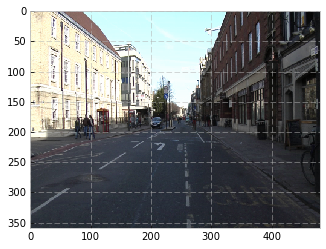

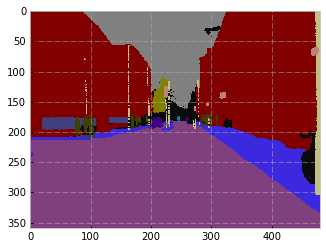

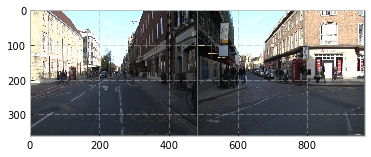

In [11]:
# Get a batch of training data
inputs, targets = next(iter(train_loader))
#inputs, targets = next(iter(val_loader))
#inputs, targets = next(iter(test_loader))

# Plot Single Image
view_image(inputs[0])

# Plot Target Image
view_annotated(targets[0])

# Plot Grid of images
out = torchvision.utils.make_grid(inputs, nrow=3)
view_image(out)

## Visdom web browser

* https://github.com/facebookresearch/visdom
* https://github.com/facebookresearch/visdom/blob/master/example/demo.py

In [12]:
visdom_enabled = True
import visdom
viz = visdom.Visdom()

In [13]:
def viz_plot_tst_trn(window, epoch, tst_val, trn_val, name='loss', env='main'):
    if window is None:
        return viz.line(
            X=np.array([epoch]),
            Y=np.array([[tst_val, trn_val]]),
            opts=dict(
                xlabel='epoch',
                ylabel=name,
                title=env+' '+name,
                legend=['Validation', 'Train']
            ),
            env=env
        )
    return viz.line(
        X=np.ones((1, 2)) * epoch,
        Y=np.expand_dims([tst_val, trn_val],0),
        win=window,
        update='append',
        env=env
    )

def viz_plot_img(window, tensor, env='main', title='Image'):
    '''
    This function draws an img on your Visdom web app. 
    It takes as input an `CxHxW` tensor `img`
    The array values can be float in [0,1] or uint8 in [0, 255]'''
    np_img = decode_image(tensor)
    np_img = np.rollaxis(np_img, 2, 0)
    viz.image(
        np_img,
        opts=dict(title=title, caption='Silly image'),
        win=window,
        env=env
    )
    
def viz_plot_text(window, text, env='main'):
    if window is None:
        return viz.text(
            text,
            env=env
        )
    return viz.text(
        text,
        win=window,
        env=env
    )

def viz_plot_summary(window, epoch, tst_loss, trn_loss,
                       tst_err, trn_err, env='main'):
    txt = ("""Epoch: %d
        Train - Loss: %d Err: %d
        Test - Loss: %d Err: %d""" % (epoch, 
        trn_loss, trn_err, tst_loss, tst_err))
    return viz_plot_text(window, txt, env)

In [14]:
#Should plot one chart and update it
txt_chart = viz_plot_summary(None, 1, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 3, 8, 7, 6)

In [15]:
#Should plot one chart and update it
sum_chart = viz_plot_text(None, 'Hello, world3!')
sum_chart = viz_plot_text(sum_chart, 'Hello, world4!')

In [16]:
#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
loss_chart = viz_plot_tst_trn(None, 9, 14, 27, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 10, 18, 30, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 11, 19, 32, 'loss')

In [17]:
#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
err_chart = viz_plot_tst_trn(None, 9, 14, 27, 'error')
err_chart = viz_plot_tst_trn(err_chart, 10, 18, 30, 'error')
err_chart = viz_plot_tst_trn(err_chart, 11, 19, 32, 'error')

In [18]:
inputs, targets = next(iter(train_loader))
img_chart = viz.image(
    np.random.rand(3,360,480),
    opts=dict(title="Image", caption='Silly random'),
)
viz_plot_img(img_chart, inputs[1])

## Loss

* https://github.com/ycszen/pytorch-ss/blob/master/loss.py
* http://pytorch.org/docs/nn.html?highlight=logsoftmax#nllloss2d
* https://github.com/SimJeg/FC-DenseNet/blob/master/metrics.py
* https://cs231n.github.io/linear-classify/#softmax-classifier

In [19]:
#2d version?
#criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

## Train

* https://github.com/pytorch/examples/blob/master/imagenet/main.py

**Hyperparameters**

* WeightInitialization = HeUniform
* Optimizer = RMSProp
* LR = .001 with exponential decay of 0.995 after each epoch
* Data Augmentation = Random Crops, Vertical Flips
* ValidationSet with early stopping based on IoU or MeanAccuracy with patience of 100 (50 during finetuning)
* WeightDecay = .0001
* Finetune with full-size images, LR = .0001
* Dropout = 0.2
* BatchNorm "we use current batch stats at training, validation, and test time"

**CamVid**

* TrainingSet = 367 frames
* ValidationSet = 101 frames
* TestSet = 233 frames
* Images of resolution 360x480
* Images "Cropped" to 224x224 for training --- center crop?
* FullRes images used for finetuning
* NumberOfClasses = 11 (output)
* BatchSize = 3

**FCDenseNet103**

* GrowthRate = 16 (k, number of filters to each denselayer adds to the ever-growing concatenated output)
* No pretraining

In [20]:
def get_predictions(output_batch):
    # Variables(Tensors) of size (bs,12,224,224)
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    # Argmax along channel axis (softmax probabilities)
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = 100.*incorrect/n_pixels
    return round(err,5)
        
def train(model, train_loader, optimizer, criterion, trainF, epoch, projectName):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        pred = get_predictions(output)
        train_err = error(pred, targets.data.cpu())
        partialEpoch = epoch + batch_idx / len(train_loader) - 1
        trainF.write('{},{},{}\n'.format(partialEpoch, loss.data[0], train_err))
        trainF.flush()
        
    save_weights(model, epoch, loss.data[0], train_err, projectName)
    save_optimizer(optimizer, epoch, projectName)
    print('Epoch {:d}: Train - Loss: {:.4f}\tErr: {:.4f}'.format(epoch, loss.data[0], train_err))
    return loss.data[0], train_err
        
def adjust_learning_rate(optimizer, epoch, decay):
    """Decay LR by `decay` every 1 epochs"""
    lr = optimizer.param_groups[0]['lr']
    lr *= (decay ** (epoch // 1))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #kaiming is first name of author whose last name is 'He' lol
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()
        
def test(model, test_loader, criterion, testF=None, epoch=1):
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        data, target = Variable(data.cuda(), volatile=True), Variable(target.cuda())
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader) #n_batches
    test_error /= len(test_loader)
    print('Test - Loss: {:.4f}, Error: {:.4f}'.format(
        test_loss, test_error))
    if testF:
        testF.write('{},{},{}\n'.format(int(epoch), test_loss, test_error))
        testF.flush()
    return test_loss, test_error
    
def save_weights(model, epoch, loss, err, sessionName, isBest=False):
    weights_fname = sessionName+'-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch+1,
            'loss':loss,
            'error': err,
            'sessionName': sessionName,
            'state_dict': model.state_dict()
        }, weights_fpath )
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest.pth')
    if isBest:
        shutil.copyfile(weights_fpath, WEIGHTS_PATH+'best.pth')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    state = torch.load(fpath)
    start_epoch = state['startEpoch']
    model.load_state_dict(state['state_dict'])
    print("loaded weights from session {} (lastEpoch {}, loss {}, error {})"
          .format(state['sessionName'], start_epoch-1, state['loss'],
                  state['error']))
    return state

def save_optimizer(optimizer, epoch, sessionName):
    optim_fname = sessionName+'-optim-%d.pth' % (epoch)
    optim_fpath = os.path.join(WEIGHTS_PATH, optim_fname)
    torch.save({
            'lastEpoch': epoch,
            'sessionName': sessionName,
            'state_dict': optimizer.state_dict()
        }, optim_fpath )
    shutil.copyfile(optim_fpath, WEIGHTS_PATH+'latest-optim.pth')

def load_optimizer(optimizer, fpath):
    print("loading optimizer '{}'".format(fpath))
    optim = torch.load(fpath)
    optimizer.load_state_dict(optim['state_dict'])
    print("loaded optimizer from session {}, lastEpoch {}"
          .format(optim['sessionName'], optim['lastEpoch']))
    
# Add patience function
# https://github.com/SimJeg/FC-DenseNet/blob/master/train.py#L176

## Config

* https://github.com/SimJeg/FC-DenseNet/blob/master/config/FC-DenseNet103.py

In [21]:
train_crop_size = (224, 224) # None for full size
n_classes = 12 #11 + background
# Training
seed = 0
learning_rate = .001
lr_sched_decay = 0.995 # Applied each epoch exponential - α=αe^−kt0,k are hyperparameters and 
weight_decay = 0.0001
num_epochs = 750
max_patience = 150
loss_function = 'crossentropy'
optimizer = 'rmsprop' # Consider adam for training on other dataset, or decrease epsilon to 1e-12

train_file = RESULTS_PATH+PROJECT_NAME+'-train.csv'
test_file = RESULTS_PATH+PROJECT_NAME+'-test.csv'
existing_weights_fpath=WEIGHTS_PATH+'latest.pth'
existing_optimizer_fpath=WEIGHTS_PATH+'latest-optim.pth'

#Finetune overrides
nEpochs=300
learning_rate=.0001

## Run

In [ ]:
# Initialize Model
model = FCDenseNet(in_channels=3, n_blocks=5, layers_per_block=5, growth_rate=16, 
                 out_chans_first_conv=48, n_classes=n_classes)
model = model.cuda()
print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))

In [ ]:
if existing_weights_fpath:
    state = load_weights(model, existing_weights_fpath)
    start_epoch = state['startEpoch']
    endEpoch = state['startEpoch'] + nEpochs
    print ('Resume training at epoch: {}'.format(state['startEpoch']))
    if os.path.exists(train_file): #assume test.csv exists
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    trainF = open(os.path.join(train_file), append_write)
    testF = open(os.path.join(test_file), append_write)
else:
    print ("Training new model from scratch")
    model.apply(weights_init)
    start_epoch = 1
    endEpoch = nEpochs
    trainF = open(os.path.join(train_file), 'w')
    testF = open(os.path.join(test_file), 'w')

cudnn.benchmark = True # ????
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if existing_optimizer_fpath:
    print("Loading existing optimizer: ", existing_optimizer_fpath)
    load_optimizer(optimizer, existing_optimizer_fpath)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

In [ ]:
loss_chart, err_chart, txt_chart = None, None, None
for epoch in range(start_epoch, endEpoch+1):
    since = time.time()
    trn_loss, trn_err = train(model, train_loader, optimizer, criterion, trainF, epoch, PROJECT_NAME)
    tst_loss, tst_err = test(model, val_loader, criterion, testF, epoch)
    time_elapsed = time.time() - since  
    print('Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    if visdom_enabled:
        loss_chart = viz_plot_tst_trn(loss_chart, epoch, tst_loss, trn_loss, 'loss', PROJECT_NAME)
        err_chart = viz_plot_tst_trn(err_chart, epoch, tst_err, trn_err, 'error', PROJECT_NAME)
        txt_chart = viz_plot_summary(txt_chart, epoch, tst_loss, trn_loss, tst_err, trn_err, PROJECT_NAME)

trainF.close()
testF.close()

## Test

In [ ]:
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()
test(model, test_loader, criterion)

In [ ]:
def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    #Takes input_loader and returns array of prediction tensors
    predictions = []
    model.eval()
    for input, target in input_loader:
        data, label = Variable(input.cuda(), volatile=True), Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

#predictions = predict_all(model, test_loader, 1)
# for out in predictions[:1]:
#     view_image(out[0][0])
#     view_annotated(out[1][0])
#     view_annotated(out[2][0])

def view_sample_predictions(n):
    #torch.cuda.manual_seed(random.randint(0,10**7))
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=n, shuffle=True)
    inputs, targets = next(iter(test_loader))
    data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(batch_size):
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])   

In [ ]:
view_sample_predictions(1)

## References

* https://github.com/mattmacy/vnet.pytorch/blob/master/train.py
* https://github.com/SimJeg/FC-DenseNet/blob/master/FC-DenseNet.py